In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
from scipy.stats import pearsonr 
from scipy.stats import norm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import glob
import os
import time
import xarray as xr

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

import seaborn as sns
sns.set_style('white')
sns.set_context("talk") #[poster, paper, talk, notebook]

import warnings; warnings.simplefilter('ignore')
mpl.rcParams['agg.path.chunksize'] = 100000

In [2]:
# fontsize, linewitch, etc.
fs_titles = 24
fs_labels = 24
fs_axes = 20
fs_text = 20
fs_legend = 20

In [3]:
def resolution(rez=3):
     
    xy_mu = (300,13500)
    xy_std = (300,15400)
    
    if rez !=3:

        xy_mu = (175,2300)
        xy_std = (175,2600)
    
    return xy_mu, xy_std

xy_mu, xy_std = resolution(3)

In [4]:
# fname = '/home/meganmason/Documents/projects/thesis/results/output/compiled_SUPERsnow_20m.nc' #ARS
# fname = '~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc' #ARS
# fname = '~/Documents/research/sierra/data/20m_analysis/compiled_SUPERsnow_20m.nc' #BSU
fname = '~/Documents/research/sierra/data/compiled_SUPERsnow.nc' #BSU

# #~~~~ ds load
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})

# #~~~~ ds peak (cloest to peak SWE dates)
dpeak = ds.isel(time=[0,7,18,30,42,49]) 
dpeak.close()
ds = dpeak

#~~~~ ds small
# which_yr = '2016'
# dsmall = ds.sel(time='{}'.format(which_yr))
# dsmall.close()

# ds = dsmall

#~~~convert to cm
ds['snow'] = ds.snow / 10
ds.attrs['units'] = 'cm'

#~~~convert to ints again
ds=ds.astype(np.int16, copy=False)

#~~~remove negatives (make them NaNs)
# ds['snow'] = ds.snow.where(ds.snow>0)


#grab 2015, 2016, 2017 nearest peak SWE
ds=ds.isel(time=slice(2,5))
ds.close()
ds.time

<xarray.DataArray 'time' (time: 3)>
array(['2015-03-06T00:00:00.000000000', '2016-04-16T00:00:00.000000000',
       '2017-04-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-03-06 2016-04-16 2017-04-01

In [5]:
# #20m hillshade (for back of final plot) ~ WHOLE BASIN
hill = es.hillshade(ds.dem)
levels=[1500,1750,2000,2250,2500,2750,3000,3250,3500,3750]
# # levels=[1500,2000,2500,3000,3500]
# fig = plt.figure(figsize=(5,5))
# # plt.imshow(hill, cmap='gray', alpha=.6)
# c = plt.contour(ds.dem[::-1], levels=levels, colors='dimgray', linewidths=.65, alpha=.9)
# # plt.clabel(c, c.levels, inline=True, fontsize=10)

In [6]:
# #3m analysis - use terrain.nc

# path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent/terrain/*.nc' #ARS
path = '/Users/meganmason491/Documents/research/sierra/data/terrain/*.nc' #BSU
fpath = glob.glob(path)
fpath

terrain=xr.open_mfdataset(fpath, concat_dim=None, combine='nested', chunks={'x':1000, 'y':1000}, parallel=True).rename({'Band1':'hillshade'}).drop('transverse_mercator') #combine='nested', 
terrain.close()

terrain=np.flip(terrain.hillshade,0) #terrain needs to be flipped!
terrain=terrain.where(ds.mask==1)
terrain=terrain.to_dataset()
terrain.close()

MergeError: conflicting values for variable 'veg' on objects to be combined. You can skip this check by specifying compat='override'.

# select subsection of data (comment to run whole basin)

In [ ]:
d = ds.isel(x=slice(8400,9400), y=slice(3000,4000))
d.close()
plt.imshow(d.snow.isel(time=1))
ds=d
ds.close()
ds

In [ ]:
#make subset dem hillshade for plot below
terr = terrain.isel(x=slice(8400,9400), y=slice(3000,4000))
print(terr)
levels_50=np.linspace(1500,4000,50)
plt.imshow(terr.hillshade)
plt.contour(ds.dem, levels=levels_50, colors='dimgray', linewidths=.45, alpha=.7)
plt.show

In [ ]:
# compute stats from xarray dataset
x_gt0 = ds.snow.where(ds.snow>0) #snow depths greater than zero
mu_gt0 = x_gt0.mean(dim=('x', 'y'))
sig_gt0 = x_gt0.std(dim=('x', 'y'))

#rescaled
# rescaled = (x_gt0 / mu_gt0) 
# print('RESCALED',rescaled)

#standardize
stdize = ((x_gt0 - mu_gt0) / sig_gt0)
# print('\nSTDIZE', stdize)


In [ ]:
# x_gt0=x_gt0.astype(np.int16,copy=False)
# stdize=stdize.astype(np.int16,copy=False)

### snow depths

mean 81
std 51
mean 202
std 105
mean 425
std 195


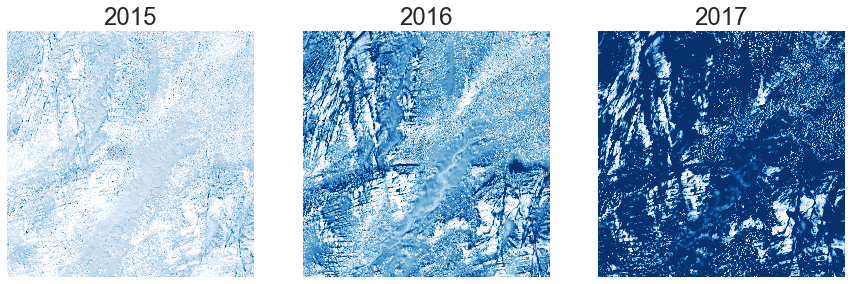

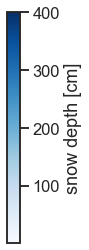

In [7]:
fig, ax=plt.subplots(1,3,figsize=(15,5))
axx=ax.flatten()

labels=[2015,2016,2017]

for i in range(3):
    c0= axx[i].imshow(x_gt0.isel(time=i), cmap='Blues', vmax=400)
#     axx[i].annotate('$\mu$ = '+ str(int(np.nanmean(x_gt0[i]))) + ' cm',
#                                      xy=xy_mu, 
#                                      fontsize=fs_labels-2)
#     axx[i].annotate('$\sigma$ = '+ str(int(np.nanstd(x_gt0[i])))+ ' cm',
#                                         xy=xy_std, 
#                                         fontsize=fs_labels-2)
    axx[i].axis('off')
    axx[i].set_title(labels[i], fontsize=fs_titles)
    
    print('mean', str(int(np.nanmean(x_gt0[i]))))
    print('std', str(int(np.nanstd(x_gt0[i]))))
    
    if i in [0]:
        axx[i].set_ylabel('snow depth', fontsize=fs_labels) #cant see it because axes are 'off'
        

# # plt.savefig('../figs/low2high_snowdepths', dpi=300, transparent=True)
# # plt.savefig('../figs/low2high_snowdepths_sub', dpi=300, transparent=True)

#colorbar
fig=plt.figure()
cx0 = fig.add_axes([.1, .1, .03, .8])
fig.colorbar(c0, cax=cx0, orientation='vertical', label='snow depth [cm]')
# cx0 = fig.add_axes([.1, .1, .8, .03])
# fig.colorbar(c0, cax=cx0, orientation='horizontal', label='snow depth [cm]')
# plt.savefig('../figs/low2high_snowdepths_cbar', dpi=300, transparent=True)

### standardized histograms

In [ ]:
fig, ax=plt.subplots(1,3,figsize=(15,5))#, sharex=True, sharey=True)
axx=ax.flatten()

for i in range(3):

    c0= axx[i].hist(stdize.isel(time=i).values.flatten(), density=True, bins=50, color='darkseagreen') 
#     axx[i].annotate('$\mu$ = '+ str(int(round(np.nanmean(stdize[i])))) + ' cm',
#                                      xy=(1.75, .53), 
#                                      fontsize=fs_labels-2)
#     axx[i].annotate('$\sigma$ = '+ str(int(round(np.nanstd(stdize[i]))))+ ' cm',
#                                         xy=(1.75, .45), 
#                                         fontsize=fs_labels-2)
    
    axx[i].grid(axis='y', color=(0.8, 0.8, 0.8), which='major', linestyle='-', linewidth=2)
    axx[i].axvline(x=0, color=(0.8, 0.8, 0.8), linestyle='--')
    axx[i].set_ylabel('frequency', fontsize=fs_axes)
    axx[i].set_xlabel('SDV', fontsize=fs_axes)
    
    axx[i].set_xticks(np.arange(-2, 5, 2))
    axx[i].set_yticks(np.arange(0, .8, .2)) 
    
    axx[i].set_xlim(-3, 5)
    axx[i].set_ylim(0,0.6)

#     if i in [0]:
#         axx[i].set_ylabel('frequency')


plt.tight_layout()   
# plt.savefig('../figs/low2high_stizeHists', dpi=300, transparent=True)
plt.savefig('../figs/low2high_stizeHists_sub', dpi=300, transparent=True)

### standardized imshow()

In [ ]:
# fig, ax=plt.subplots(1,3,figsize=(15,5))
# axx=ax.flatten()

# for i in range(3):
    
# #     axx[i].imshow(hill, cmap='gray', alpha=.6) #hillshade
    
    
#     c0= axx[i].imshow(stdize.isel(time=i), cmap='coolwarm', vmin=-3 ,vmax=3)
#     axx[i].annotate('$\mu$ = '+ str(int(round(np.nanmean(stdize[i])))) + ' cm',
#                                      xy=xy_mu, 
#                                      fontsize=fs_labels-2)
#     axx[i].annotate('$\sigma$ = '+ str(int(round(np.nanstd(stdize[i]))))+ ' cm',
#                                         xy=xy_std, 
#                                         fontsize=fs_labels-2)
#     axx[i].axis('off')

     
#     if i in [0]:
#         axx[i].set_ylabel('snow depth', fontsize=fs_labels) #cant see it because axes are 'off'

# # plt.savefig('../figs/low2high_standardized', dpi=300, transparent=True)
        
# #colorbar
# fig=plt.figure()
# cx0 = fig.add_axes([.1, .1, .03, .8])
# fig.colorbar(c0, cax=cx0, orientation='vertical', label='[cm]')
# # plt.savefig('../figs/low2high_standardized_cbar', dpi=300, transparent=True)

### where's deep, where's shallow?!
plotting deep as everything consistently 1 std or greater, plotting shallow as everything that is consistently -1 std or less

In [ ]:
# fig, ax=plt.subplots(1,3,figsize=(15,5))
# axx=ax.flatten()

# discrete_blue = plt.cm.get_cmap('Blues', 1)
# discrete_red = plt.cm.get_cmap('Reds', 1)
# # discrete_red = plt.cm.get_cmap('seismic', 3)

# #question- can use make imshow just one color (blue and red) vs a color gradient?
# #add hillshade!?!?! from bsu...

# for i in range(3):
    
    
#     axx[i].imshow(hill, cmap='gray', alpha=.2) #hillshade
#     axx[i].contour(ds.dem, levels=levels, colors='dimgray', linewidths=.45, alpha=.7)

#     #deep
#     deep = stdize.isel(time=i).where(stdize>=1)
# #     deep = deep.astype(np.int16,copy=False)
    
#     c0=axx[i].imshow(deep.isel(time=i), cmap= 'Blues', vmin=1, vmax=2)     #cmap='Blues_r', vmin=2, vmax=3)
    
#     #shallow
#     shal = stdize.isel(time=i).where(stdize<=-1)
# #     shal = shal.astype(np.int16,copy=False)
#     c1=axx[i].imshow(shal.isel(time=i),cmap='Reds_r', vmin=-2, vmax=-1)       #cmap='Reds', vmin=-3, vmax=-2)

#     axx[i].axis('off')

     
#     if i in [0]:
#         axx[i].set_ylabel('deep/shallow zones', fontsize=fs_labels) #cant see it because axes are 'off'
        
# # plt.savefig('../figs/low2high_deepShallow', dpi=300, transparent=True)

# #colorbar
# fig=plt.figure()
# cx0 = fig.add_axes([.1, .37, .75, .05])
# cx1 = fig.add_axes([.1, .1, .75, .05])
# fig.colorbar(c0, cax=cx0, orientation='horizontal')
# fig.colorbar(c1, cax=cx1, orientation='horizontal')
# # plt.savefig('../figs/low2high_deepShallow_cbar', dpi=300, transparent=True)



In [ ]:
from matplotlib import colors 
fig, ax=plt.subplots(1,3,figsize=(15,5))
axx=ax.flatten()

# discrete_blue = plt.cm.get_cmap('Blues', 1)
# discrete_red = plt.cm.get_cmap('Reds', 1)

newcmap = colors.ListedColormap(['indianred', 'indianred','white', 'white', 'navy','navy', 'navy'])
bounds=[-3,-2,-1, 0, 1, 2, 3] #np.linspace(-3,3,1)
norm = colors.BoundaryNorm(bounds, newcmap.N)

                              # discrete_red = plt.cm.get_cmap('seismic', 3)

#question- can use make imshow just one color (blue and red) vs a color gradient?
#add hillshade!?!?! from bsu...

for i in range(3):
    
    #whole basin (20m)
    axx[i].imshow(hill, cmap='gray', alpha=.2) #hillshade
    axx[i].contour(ds.dem, levels=levels, colors='dimgray', linewidths=.45, alpha=.7)
    
    #subbasin (3m)
#     axx[i].imshow(terr.hillshade, cmap='gray', alpha=.2) #hillshade
#     axx[i].contour(ds.dem, levels=levels_50, colors='dimgray', linewidths=.45, alpha=.7)

    #deep
    deep = stdize.isel(time=i).where(stdize>=1)
#     deep = deep.astype(np.int16,copy=False)
    
    c0=axx[i].imshow(deep.isel(time=i), norm=norm, cmap=newcmap, vmin=-3, vmax=3)     #cmap='Blues_r', vmin=2, vmax=3)
    
    #shallow
    shal = stdize.isel(time=i).where(stdize<=-1)
#     shal = shal.astype(np.int16,copy=False)
    c1=axx[i].imshow(shal.isel(time=i),norm=norm, cmap=newcmap, vmin=-3, vmax=3)       #cmap='Reds', vmin=-3, vmax=-2)

    axx[i].axis('off')

     
    if i in [0]:
        axx[i].set_ylabel('deep/shallow zones', fontsize=fs_labels) #cant see it because axes are 'off'
        
# plt.savefig('../figs/low2high_deepShallow', dpi=300, transparent=True)
# plt.savefig('../figs/low2high_deepShallow_sub', dpi=300, transparent=True)

#colorbar
fig=plt.figure()
cx0 = fig.add_axes([.1, .1, .03, .8])
fig.colorbar(c0, cax=cx0, orientation='vertical', label='standardized depth values (SDV)')
plt.savefig('../figs/low2high_deepShallow_cbar', dpi=300, transparent=True)

